<a id='main' name="main"></a>
# Vital Data Analysis

Date: 2022.10.17  
Author: © 2022 Julius Gudauskas

This notebook is part of an individual project for [KTU IF](https://fi.ktu.edu/)  [P176M010 Advanced Machine Learning](https://admissions.ktu.edu/programme/m-software-engineering/#P176M010) class led by [M. Lukoševičius](http://mantas.info/).

In this work we answer the questions:
1. [Do countries with a greater average of beds per thousand people have less death rate compared to other countries? Take into account covid and other diseases from num. of deaths by cause dataset.](#Q1)
2. [Can we predict different disease death rates from death rates by various risks (pollution, alcohol use, unsafe water sources, etc.) using supervised machine learning?](#Q2)
3. [Can we predict the number of hospital patients from new cases per million and new deaths in countries where the data exist?](#Q3)

Using the open data from: 
* [Our World in Data](https://ourworldindata.org/) COVID-19 data from <https://covid.ourworldindata.org/data/owid-covid-data.csv>
* [Our World in Data](https://ourworldindata.org/) Annual number of deaths by cause from <https://ourworldindata.org/grapher/annual-number-of-deaths-by-cause>
* [Our World in Data](https://ourworldindata.org/) Annual number of deaths by cause from <https://ourworldindata.org/grapher/number-of-deaths-by-risk-factor>

This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International license</a>. <a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons licencija" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/80x15.png" /></a> 

In [143]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor 
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_absolute_percentage_error
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, Dropout

pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Load the data

Download the data to cache locally. Do this once (a day), and comment out, not to DoS the server. (adopted from https://stackoverflow.com/a/35997720).

In [144]:
# import requests
# fname = 'owid-covid-data.csv'
# url = 'https://covid.ourworldindata.org/data/' + fname
# r = requests.get(url)
# open(fname, 'wb').write(r.content)

Load the file to Pandas.

In [145]:
#url = "https://covid.ourworldindata.org/data/owid-covid-data.csv"
# download the file locally when developing, not to DoS the server:

url1 = "owid-covid-data.csv" 
url2 = "annual-number-of-deaths-by-cause.csv" 
url3 = "number-of-deaths-by-risk-factor.csv" 

covidData = pd.read_csv(url1, parse_dates=[3])
deathsByDisease = pd.read_csv(url2, parse_dates=[3])
deathsByDisease = deathsByDisease.rename(columns={deathsByDisease.columns[0]:"location", deathsByDisease.columns[4]:"Meningitis", deathsByDisease.columns[5]:"Alzheimers", deathsByDisease.columns[6]:"Parkinsons",deathsByDisease.columns[8]:"Malaria",deathsByDisease.columns[12]:"HIV/AIDS",deathsByDisease.columns[14]:"Tuberculosis"})
deathsByDisease = deathsByDisease[["location", "Year", "Meningitis", "Alzheimers", "Parkinsons", "Malaria", "HIV/AIDS", "Tuberculosis"]]

deathsByRisk = pd.read_csv(url3, parse_dates=[3])
deathsByRisk = deathsByRisk.rename(columns={deathsByRisk.columns[0]:"location"})

These are available datasets columns

In [146]:
covidData.info()
deathsByDisease.info()
deathsByRisk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222835 entries, 0 to 222834
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   iso_code                                    222835 non-null  object        
 1   continent                                   210032 non-null  object        
 2   location                                    222835 non-null  object        
 3   date                                        222835 non-null  datetime64[ns]
 4   total_cases                                 213687 non-null  float64       
 5   new_cases                                   213398 non-null  float64       
 6   new_cases_smoothed                          212202 non-null  float64       
 7   total_deaths                                194543 non-null  float64       
 8   new_deaths                                  194470 non-null  float64      

The columns are explained [here](https://github.com/owid/covid-19-data/blob/master/public/data/owid-covid-codebook.csv).

In [147]:
covidData.describe()

,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
count,213687.00000,213398.00000,212202.00000,194543.00000,194470.00000,193290.00000,212710.00000,212421.00000,211230.00000,193579.00000,...,138265.00000,136372.00000,89914.00000,162559.00000,208223.00000,178165.00000,7460.00000,7460.00000,7507.00000,7460.00000
mean,4333736.31206,12424.98205,12464.85445,73260.18532,140.03862,140.77192,58512.68778,189.90567,190.14554,682.49494,...,10.67479,32.80890,50.93419,3.08919,73.61995,0.72482,47096.10556,9.79891,14.50373,1303.26772
std,27128979.93021,85687.02664,83767.70558,377147.75213,735.12701,720.70308,104239.97856,1054.18583,668.41912,968.70085,...,10.62508,13.53440,31.88336,2.55250,7.44617,0.14961,130558.78706,13.59622,26.62374,1698.24194
min,1.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00100,0.00000,0.00000,0.00000,...,0.10000,7.70000,1.18800,0.10000,53.28000,0.39400,-37726.10000,-28.45000,-95.92000,-1884.67898
25%,4161.50000,0.00000,6.14300,112.00000,0.00000,0.00000,1047.98400,0.00000,1.36900,28.93200,...,1.90000,21.60000,20.85900,1.30000,69.50000,0.60200,28.67500,0.43000,-0.16000,19.95227
50%,47608.00000,56.00000,96.00000,1152.00000,1.00000,1.57100,9923.32450,7.81800,19.62700,207.19000,...,6.30000,31.40000,49.83900,2.50000,75.05000,0.74200,5716.25000,7.30000,7.38000,772.39963
75%,513434.50000,970.00000,1136.10725,9675.00000,14.00000,16.00000,70418.35000,98.41300,136.26600,1011.81300,...,19.30000,41.30000,83.24100,4.20000,79.07000,0.84500,33558.05000,15.36250,20.15000,2022.75564
max,621868983.00000,4081740.00000,3436271.57100,6558494.00000,17737.00000,14858.14300,659350.87600,195005.31300,36401.60700,6429.92600,...,44.00000,78.10000,100.00000,13.80000,86.75000,0.95700,1220576.90000,76.55000,376.25000,9766.30688


In [148]:
deathsByDisease.describe()

,Year,Meningitis,Alzheimers,Parkinsons,Malaria,HIV/AIDS,Tuberculosis
count,7273.00000,6840.00000,6840.00000,6840.00000,6840.00000,6840.00000,6840.00000
mean,2004.42513,8213.14942,27363.18947,6493.62880,18903.16126,28141.25015,37153.22588
std,8.62357,34982.93446,111314.60660,25767.44674,97346.78173,139197.34582,159572.07475
min,1990.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,1997.00000,19.00000,128.75000,37.00000,0.00000,14.00000,43.00000
50%,2004.00000,150.50000,845.50000,209.00000,0.00000,187.00000,550.00000
75%,2012.00000,1622.25000,4251.00000,984.00000,1017.25000,3836.50000,5256.00000
max,2019.00000,432524.00000,1623276.00000,362907.00000,961129.00000,1844490.00000,1808478.00000


In [149]:
deathsByRisk.describe()

,Year,Deaths - Cause: All causes - Risk: High systolic blood pressure - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Diet high in sodium - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Diet low in whole grains - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Alcohol use - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Diet low in fruits - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Unsafe water source - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Secondhand smoke - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Low birth weight - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Child wasting - Sex: Both - Age: All Ages (Number),...,Deaths - Cause: All causes - Risk: High body-mass index - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Unsafe sanitation - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: No access to handwashing facility - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Drug use - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Low bone mineral density - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Vitamin A deficiency - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Child stunting - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Discontinued breastfeeding - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Non-exclusive breastfeeding - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Iron deficiency - Sex: Both - Age: All Ages (Number)
count,6840.00000,6840.00000,6840.00000,6840.00000,6840.00000,6840.00000,6840.00000,6840.00000,6840.00000,6840.00000,...,6840.00000,6840.00000,6840.00000,6840.00000,6840.00000,6840.00000,6840.00000,6840.00000,6840.00000,6840.00000
mean,2004.50000,224224.86096,40497.16228,38691.29298,54848.60351,23957.76184,44086.38304,30364.00673,59125.51447,49924.36623,...,89869.91652,31521.54825,21799.89488,10285.20263,8182.47427,2471.59474,11164.33187,431.45760,7171.85292,1421.36316
std,8.65607,863469.13381,175283.18994,147908.40077,211208.99671,94515.73055,202049.29705,122286.06053,250226.51391,222652.89897,...,345042.02372,146343.43100,96682.58587,39960.74594,32403.92204,12718.30361,52866.24525,1901.53112,31678.44583,6303.93030
min,1990.00000,2.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,...,2.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,1997.00000,1827.75000,137.00000,273.00000,263.75000,144.00000,7.00000,209.00000,123.00000,26.00000,...,918.50000,3.00000,19.00000,31.00000,43.00000,0.00000,1.00000,0.00000,3.00000,1.00000
50%,2004.50000,8770.50000,969.50000,1444.00000,1780.50000,834.50000,182.50000,993.50000,1057.00000,504.00000,...,3917.00000,102.00000,221.00000,222.00000,277.00000,2.00000,41.50000,4.00000,60.50000,12.00000
75%,2012.00000,40355.50000,5169.75000,6773.25000,8368.00000,3104.75000,5599.25000,4347.75000,10903.25000,9764.75000,...,17967.75000,3854.00000,3953.50000,1224.25000,1232.00000,230.25000,1563.25000,71.25000,1315.50000,238.00000
max,2019.00000,10845595.00000,1885356.00000,1844836.00000,2441973.00000,1046015.00000,2450944.00000,1304318.00000,3033425.00000,3430422.00000,...,5019360.00000,1842275.00000,1200349.00000,494492.00000,437884.00000,207555.00000,833449.00000,33106.00000,505470.00000,73461.00000


[back to the top](#main)
<a id='Q1' name='Q1'></a>
## 1. Do countries with a greater average of beds per thousand people have less death rate compared to other countries? Take into account covid and other diseases from num. of deaths by cause dataset. 

First of all, let's obtain what is the average of beds per thousand and a total of covid deaths values are in different countries.

In [150]:
df = covidData
df = df.dropna(subset=["location", "hospital_beds_per_thousand", "total_deaths_per_million"])
countries = df["location"].unique()
bedByCountry = pd.DataFrame()
for i in range(len(countries)):
    values = df.loc[df["location"] == countries[i]]
    bedsCount = values["hospital_beds_per_thousand"].mean()
    deaths = values["total_deaths_per_million"].max()
    bedByCountry = pd.concat([bedByCountry, pd.DataFrame.from_records([{ 'Country': countries[i], 'Beds': bedsCount, 'Covid': deaths }])])

bedByCountry = bedByCountry.sort_values(by=["Beds"], ascending=False)
print(bedByCountry)


        Country     Beds      Covid
0        Monaco 13.80000 1717.27600
0   North Korea 13.20000    0.23100
0         Japan 13.05000  366.25500
0   South Korea 12.27000  553.88600
0       Belarus 11.00000  743.14800
..          ...      ...        ...
0         Nepal  0.30000  400.13300
0      Ethiopia  0.30000   62.95200
0        Guinea  0.30000   33.62400
0    Madagascar  0.20000   48.76300
0          Mali  0.10000   33.87400

[172 rows x 3 columns]


Not we need to gather different disease death rates from all countries that are available in dataset. For the further analysis, let's map gthered data to covid dataset.

In [151]:
df = deathsByDisease
df = df.dropna(subset=["location", "Meningitis", "Alzheimers", "Parkinsons", "Malaria", "HIV/AIDS", "Tuberculosis"])
countries = df["location"].unique()
variousDeaths = pd.DataFrame()
for i in range(len(countries)):
    values = df.loc[df["location"] == countries[i]]
    values = values.sort_values(by=["Year"], ascending=False)
    
    meningitis = values["Meningitis"].iat[0]
    alzheimers = values["Alzheimers"].iat[0]
    parkinsons = values["Parkinsons"].iat[0]
    malaria = values["Malaria"].iat[0]
    hiv_aids = values["HIV/AIDS"].iat[0]
    tuberculosis = values["Tuberculosis"].iat[0]

    variousDeaths = pd.concat([variousDeaths, pd.DataFrame.from_records([{ 'Country': countries[i], 'Meningitis': meningitis, 'Alzheimers':alzheimers, 'Parkinsons':parkinsons, 'Malaria': malaria, 'HIV/AIDS':hiv_aids, 'Tuberculosis': tuberculosis}])])

deathsRates = pd.merge(bedByCountry, variousDeaths, on='Country')
print(deathsRates)

         Country     Beds      Covid  Meningitis   Alzheimers  Parkinsons  \
0         Monaco 13.80000 1717.27600     0.00000     28.00000     7.00000   
1    North Korea 13.20000    0.23100   223.00000   5208.00000  1296.00000   
2          Japan 13.05000  366.25500   407.00000 164874.00000 16750.00000   
3    South Korea 12.27000  553.88600    77.00000  18451.00000  3730.00000   
4        Belarus 11.00000  743.14800    49.00000   3685.00000   632.00000   
..           ...      ...        ...         ...          ...         ...   
166        Nepal  0.30000  400.13300   469.00000   2448.00000   875.00000   
167     Ethiopia  0.30000   62.95200 11283.00000   6433.00000  1230.00000   
168       Guinea  0.30000   33.62400  3260.00000    931.00000   264.00000   
169   Madagascar  0.20000   48.76300  2084.00000    859.00000   208.00000   
170         Mali  0.10000   33.87400  6260.00000   1226.00000   325.00000   

        Malaria    HIV/AIDS  Tuberculosis  
0       0.00000     1.00000    

Now that we gathered all the neccessary info we can take a closer look what kind of data we have and what possible problems could occur.

In [152]:
deathsRates.describe()

,Beds,Covid,Meningitis,Alzheimers,Parkinsons,Malaria,HIV/AIDS,Tuberculosis
count,171.00000,171.00000,171.00000,171.00000,171.00000,171.00000,171.00000,171.00000
mean,3.07594,1310.66273,2361.67836,18770.49708,4190.92982,5603.42105,9140.76023,12968.16959
std,2.54884,1338.38844,18288.61820,127467.95978,28582.98446,49367.09319,67211.66490,95773.14557
min,0.10000,0.23100,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,1.30000,189.45450,14.00000,244.50000,61.50000,0.00000,24.50000,41.00000
50%,2.50000,955.71400,77.00000,1477.00000,341.00000,0.00000,181.00000,329.00000
75%,4.10000,2021.57450,461.00000,5129.50000,1174.50000,56.00000,1714.50000,2284.50000
max,13.80000,6429.92600,236222.00000,1623276.00000,362907.00000,643381.00000,863837.00000,1179766.00000


From the collected data analysis we can see that there are quite a huge number of undefined values (values that are 0). To make erything more clear, in the further analysis lets use only the countries that has records about death rates.

Also we can see that the maximum value of some disease death rates are way bigger than the 0.75 quantile. That means there might be some data noise with huge values that can harm our analysis. We need to look into that.

In [153]:
def draw(axis, xindex, yindex, variable):
    data = deathsRates[(deathsRates[variable] > 0) & (deathsRates[variable] < deathsRates[variable].quantile(.75))]
    X = data["Beds"]
    Y = data[variable]
    z = np.polyfit(X, Y, 1)
    p = np.poly1d(z)
    axis[xindex, yindex].scatter(X, Y, label = 'Testing dataset Accuracy')
    axis[xindex, yindex].plot(X, p(X), color="purple", linewidth=3, linestyle="--")
    axis[xindex, yindex].set_title(variable)

After some experiments decided to use data records that are below 0.75 quantile (there are only some values out of this range, but these values are very big and disturb analysis).

So the goal of this question is to identify if bigger "beds per thousand people" vaues have smaller mortality rates. With this goal in mind decided to use scatter plot with trend line.

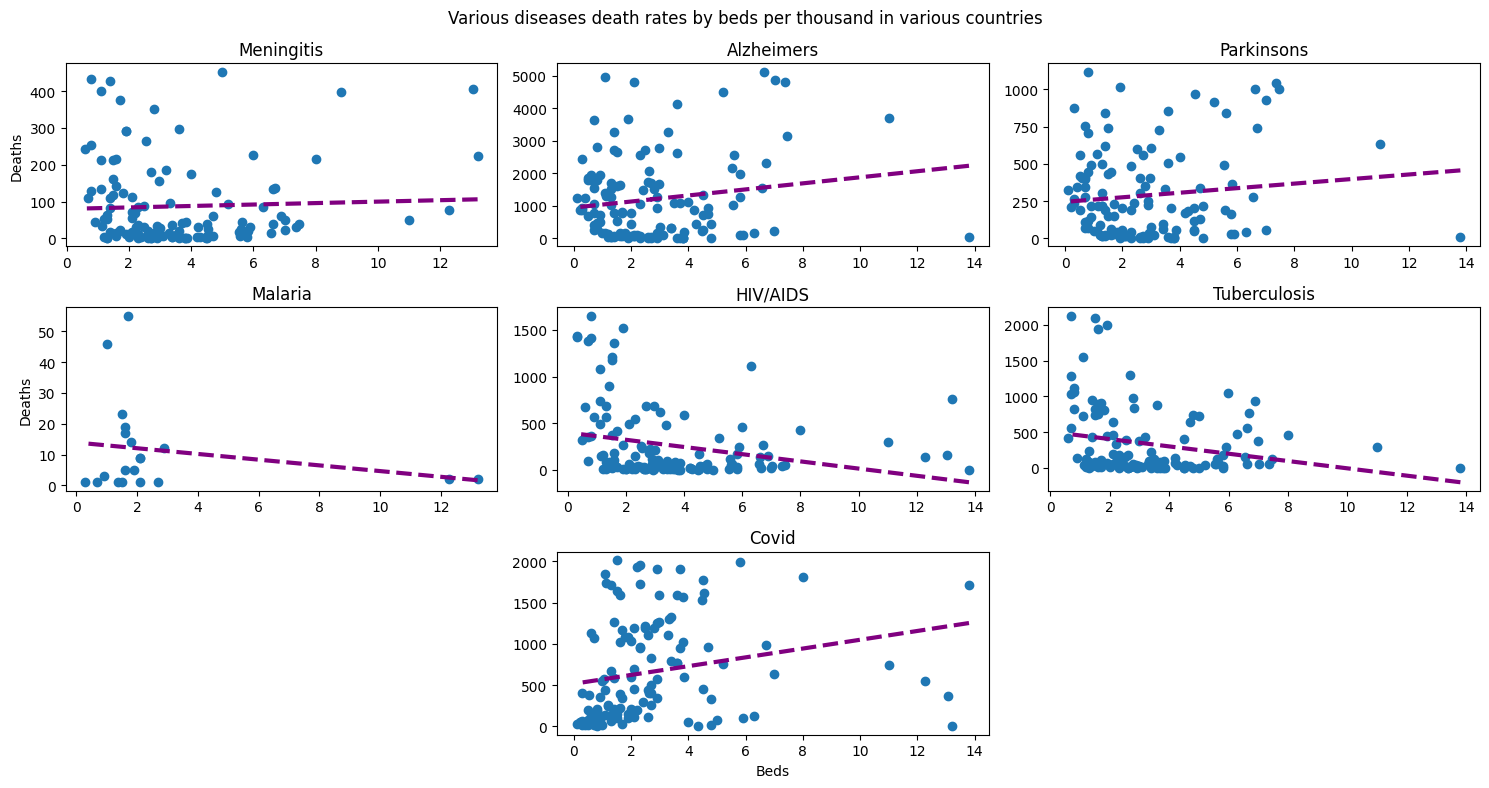

In [154]:

figure, axis = plt.subplots(3, 3, figsize=(15, 8))
figure.delaxes(axis[2][0])
figure.delaxes(axis[2][2])

draw(axis, 0, 0,"Meningitis")
draw(axis, 0, 1,"Alzheimers")
draw(axis, 0, 2,"Parkinsons")
draw(axis, 1, 0,"Malaria")
draw(axis, 1, 1,"HIV/AIDS")
draw(axis, 1, 2,"Tuberculosis")
draw(axis, 2, 1,"Covid")

figure.suptitle("Various diseases death rates by beds per thousand in various countries")

plt.setp(axis[-1, :], xlabel="Beds")
plt.setp(axis[:, 0], ylabel="Deaths")

figure.tight_layout()

From the chart above we can see that some disease death rates show us a trend that as the number of beds increases, the mortality rate decreases (Malaria, HIV/AIDS, Tuberculosis). But for Parkinson, Alzheimers and Covid death this trend does not apply and values here are distributed similary despite the beds count.

To conclude, from the results we can see that countries with a greater average of beds per thousand people have less death rate compared to other countries but this thrend is visible only for a few diseases (Malaria, HIV/AIDS, Tuberculosis). Other disease death rates are spreaded despite the bed for thousand people cound.

[back to the top](#main)
<a id='Q2' name='Q2'></a>
## 2. Can we predict different disease death rates from death rates by various risks (pollution, alcohol use, unsafe water sources, etc.) using supervised machine learning?

First of all let's do the dataset analysis. We can see that there are quite a few undefined values (0). Also, max values is even few times bigger than 0.75 quantile. That's the same as we saw in death rates by different diseases dataset.

In [155]:
deathsByRisk.describe()

,Year,Deaths - Cause: All causes - Risk: High systolic blood pressure - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Diet high in sodium - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Diet low in whole grains - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Alcohol use - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Diet low in fruits - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Unsafe water source - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Secondhand smoke - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Low birth weight - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Child wasting - Sex: Both - Age: All Ages (Number),...,Deaths - Cause: All causes - Risk: High body-mass index - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Unsafe sanitation - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: No access to handwashing facility - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Drug use - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Low bone mineral density - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Vitamin A deficiency - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Child stunting - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Discontinued breastfeeding - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Non-exclusive breastfeeding - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Iron deficiency - Sex: Both - Age: All Ages (Number)
count,6840.00000,6840.00000,6840.00000,6840.00000,6840.00000,6840.00000,6840.00000,6840.00000,6840.00000,6840.00000,...,6840.00000,6840.00000,6840.00000,6840.00000,6840.00000,6840.00000,6840.00000,6840.00000,6840.00000,6840.00000
mean,2004.50000,224224.86096,40497.16228,38691.29298,54848.60351,23957.76184,44086.38304,30364.00673,59125.51447,49924.36623,...,89869.91652,31521.54825,21799.89488,10285.20263,8182.47427,2471.59474,11164.33187,431.45760,7171.85292,1421.36316
std,8.65607,863469.13381,175283.18994,147908.40077,211208.99671,94515.73055,202049.29705,122286.06053,250226.51391,222652.89897,...,345042.02372,146343.43100,96682.58587,39960.74594,32403.92204,12718.30361,52866.24525,1901.53112,31678.44583,6303.93030
min,1990.00000,2.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,...,2.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,1997.00000,1827.75000,137.00000,273.00000,263.75000,144.00000,7.00000,209.00000,123.00000,26.00000,...,918.50000,3.00000,19.00000,31.00000,43.00000,0.00000,1.00000,0.00000,3.00000,1.00000
50%,2004.50000,8770.50000,969.50000,1444.00000,1780.50000,834.50000,182.50000,993.50000,1057.00000,504.00000,...,3917.00000,102.00000,221.00000,222.00000,277.00000,2.00000,41.50000,4.00000,60.50000,12.00000
75%,2012.00000,40355.50000,5169.75000,6773.25000,8368.00000,3104.75000,5599.25000,4347.75000,10903.25000,9764.75000,...,17967.75000,3854.00000,3953.50000,1224.25000,1232.00000,230.25000,1563.25000,71.25000,1315.50000,238.00000
max,2019.00000,10845595.00000,1885356.00000,1844836.00000,2441973.00000,1046015.00000,2450944.00000,1304318.00000,3033425.00000,3430422.00000,...,5019360.00000,1842275.00000,1200349.00000,494492.00000,437884.00000,207555.00000,833449.00000,33106.00000,505470.00000,73461.00000


In [156]:
df = deathsByRisk
df = df.dropna()
deathsInCountries = pd.merge(deathsByRisk, deathsByDisease, on=['location', 'Year'])
deathsInCountries.describe()
deathsInCountries.head()

deathsInCountries.corr()


,Year,Deaths - Cause: All causes - Risk: High systolic blood pressure - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Diet high in sodium - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Diet low in whole grains - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Alcohol use - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Diet low in fruits - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Unsafe water source - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Secondhand smoke - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Low birth weight - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Child wasting - Sex: Both - Age: All Ages (Number),...,Deaths - Cause: All causes - Risk: Child stunting - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Discontinued breastfeeding - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Non-exclusive breastfeeding - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Iron deficiency - Sex: Both - Age: All Ages (Number),Meningitis,Alzheimers,Parkinsons,Malaria,HIV/AIDS,Tuberculosis
Year,1.00000,0.03159,0.02300,0.02944,0.02594,0.01478,-0.04530,0.00310,-0.03836,-0.08245,...,-0.09651,-0.08886,-0.08228,-0.04082,-0.04182,0.07648,0.06791,-0.01532,0.01764,-0.03205
Deaths - Cause: All causes - Risk: High systolic blood pressure - Sex: Both - Age: All Ages (Number),0.03159,1.00000,0.95482,0.99223,0.99242,0.98289,0.67653,0.97031,0.74476,0.63609,...,0.58727,0.63290,0.64656,0.68490,0.68190,0.94198,0.97189,0.48232,0.56969,0.77011
Deaths - Cause: All causes - Risk: Diet high in sodium - Sex: Both - Age: All Ages (Number),0.02300,0.95482,1.00000,0.91939,0.94975,0.95265,0.58101,0.97704,0.65618,0.56682,...,0.51762,0.56608,0.58079,0.59300,0.60165,0.89020,0.92291,0.39962,0.50040,0.69591
Deaths - Cause: All causes - Risk: Diet low in whole grains - Sex: Both - Age: All Ages (Number),0.02944,0.99223,0.91939,1.00000,0.98575,0.96337,0.65979,0.94139,0.72890,0.61964,...,0.57332,0.62002,0.63003,0.66840,0.66458,0.94013,0.96568,0.46824,0.55341,0.74596
Deaths - Cause: All causes - Risk: Alcohol use - Sex: Both - Age: All Ages (Number),0.02594,0.99242,0.94975,0.98575,1.00000,0.97363,0.66622,0.96133,0.73162,0.64040,...,0.59092,0.63923,0.65164,0.67614,0.68547,0.94322,0.96997,0.50072,0.59407,0.75761
Deaths - Cause: All causes - Risk: Diet low in fruits - Sex: Both - Age: All Ages (Number),0.01478,0.98289,0.95265,0.96337,0.97363,1.00000,0.74984,0.98839,0.81167,0.69719,...,0.65292,0.68356,0.70519,0.75406,0.73251,0.88776,0.93489,0.50815,0.57796,0.84228
Deaths - Cause: All causes - Risk: Unsafe water source - Sex: Both - Age: All Ages (Number),-0.04530,0.67653,0.58101,0.65979,0.66622,0.74984,1.00000,0.71368,0.98504,0.95966,...,0.95257,0.92074,0.94670,0.99110,0.95507,0.51365,0.58365,0.80302,0.71956,0.98214
Deaths - Cause: All causes - Risk: Secondhand smoke - Sex: Both - Age: All Ages (Number),0.00310,0.97031,0.97704,0.94139,0.96133,0.98839,0.71368,1.00000,0.78350,0.68571,...,0.64202,0.68054,0.69706,0.72260,0.70974,0.87212,0.91852,0.47942,0.54788,0.81275
Deaths - Cause: All causes - Risk: Low birth weight - Sex: Both - Age: All Ages (Number),-0.03836,0.74476,0.65618,0.72890,0.73162,0.81167,0.98504,0.78350,1.00000,0.94757,...,0.93131,0.91945,0.94092,0.98994,0.95249,0.57855,0.64937,0.77508,0.71762,0.98936
Deaths - Cause: All causes - Risk: Child wasting - Sex: Both - Age: All Ages (Number),-0.08245,0.63609,0.56682,0.61964,0.64040,0.69719,0.95966,0.68571,0.94757,1.00000,...,0.99462,0.98159,0.99365,0.96132,0.97808,0.47432,0.53461,0.86546,0.76123,0.93380


From the correlation matrix we can see that some of the varaibles have very big correlation index (for example Alzheimers and Parkinsons highly correlate with High systolic blood pressure deat rates.) That's promising and we can expect successful predictions.

For the prediction decided to start with K nearest neighbors supervised machine learning model. 

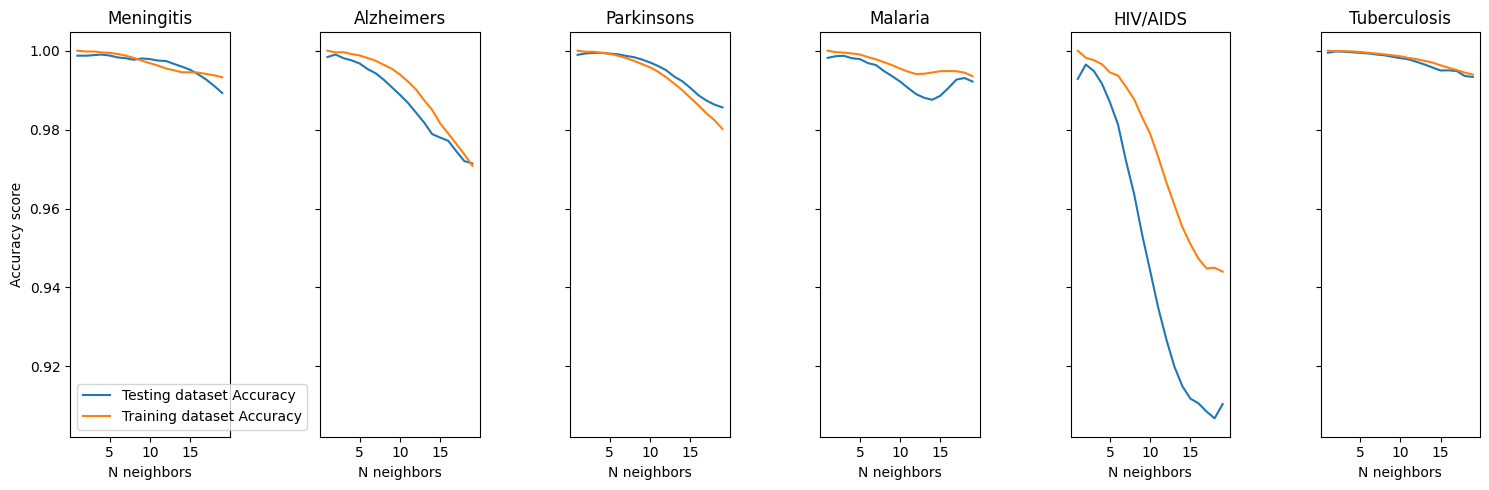

In [157]:
#Code is based on article on https://www.geeksforgeeks.org/k-nearest-neighbor-algorithm-in-python/

figure, axis = plt.subplots(1, 6, figsize=(15, 5), sharey=True)
index = 0

for i in range (31, 37):
    
    colname = deathsInCountries.columns[i]
    data = deathsInCountries[deathsInCountries[colname] > 0]

    X = data.iloc[ : , 4 : 31]
    Y = data.iloc[ : , i ]

    Y = [[el] for el in Y]
    
    scaler = MinMaxScaler(feature_range=(0,1))
    X = scaler.fit_transform(X)
    Y = scaler.fit_transform(Y)
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=10)

    neighbors = np.arange(1, 20)
    train_accuracy = np.empty(len(neighbors))
    test_accuracy = np.empty(len(neighbors))
    
    for i, k in enumerate(neighbors):
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(X_train, y_train)
        
        train_accuracy[i] = knn.score(X_train, y_train)
        test_accuracy[i] = knn.score(X_test, y_test)
    
    axis[index].plot(neighbors, test_accuracy, label = 'Testing dataset Accuracy')
    axis[index].plot(neighbors, train_accuracy, label = 'Training dataset Accuracy')

    axis[index].set_title(colname)
    index = index + 1

axis[0].legend()
plt.setp(axis[:], xlabel='N neighbors')
plt.setp(axis[0], ylabel='Accuracy score')

figure.tight_layout()


From the chart above we can see that majority of disease death rates can be pretty accuratelly predicted using death rates by various risks in different countries.

Let's further investigate how well we can predict selected diseases death rates using Decision tree supervised machine learning model.
The model was construced using all the variables from death rates by different factors dataset. Model was evaluated using model score and mean absolute precentage error.

In [158]:
def predictionMetrics(title, X_train_data, Y_train_data, X_test_data, Y_test_data):
    regressor = DecisionTreeRegressor(random_state = 10, max_depth=7)
    regressor.fit(X_train_data, Y_train_data)

    predictions = regressor.predict(X_test_data)
    roundedPredictions = [round(n, 3) for n in predictions]
    predAndActual = [list(a) for a in zip(roundedPredictions, Y_test_data)]
    print(title)
    print("[predicted , actual]")
    print(predAndActual[0:5])

    score = regressor.score(X_test_data, Y_test_data)
    print("Score: " + str(score))
    score2 = mean_absolute_percentage_error(Y_test_data, predictions )
    print("mean absolute percentage error: " + str(score2))
    print("---------------------------------")

Meningitis
[predicted , actual]
[[46085.75, 42711.0], [177.345, 132.0], [177.345, 96.0], [10282.604, 14587.0], [177.345, 135.0]]
Score: 0.9917303418236952
mean absolute percentage error: 2.611243473859494
---------------------------------
Alzheimers
[predicted , actual]
[[2317.742, 2022.0], [603.97, 432.0], [1179.422, 912.0], [4365.747, 3747.0], [603.97, 256.0]]
Score: 0.99410833338524
mean absolute percentage error: 2.135847584469956
---------------------------------
Parkinsons
[predicted , actual]
[[107.065, 150.0], [15.889, 6.0], [15.889, 17.0], [585.447, 1356.0], [1004.525, 957.0]]
Score: 0.9938483040150512
mean absolute percentage error: 1.0440835745644121
---------------------------------
Malaria
[predicted , actual]
[[7232.828, 4545.0], [9629.888, 12530.0], [25706.052, 20425.0], [170.989, 91.0], [2703.83, 4565.0]]
Score: 0.9958721098006098
mean absolute percentage error: 20.665940514689957
---------------------------------
HIV/AIDS
[predicted , actual]
[[81269.556, 94706.0], [87

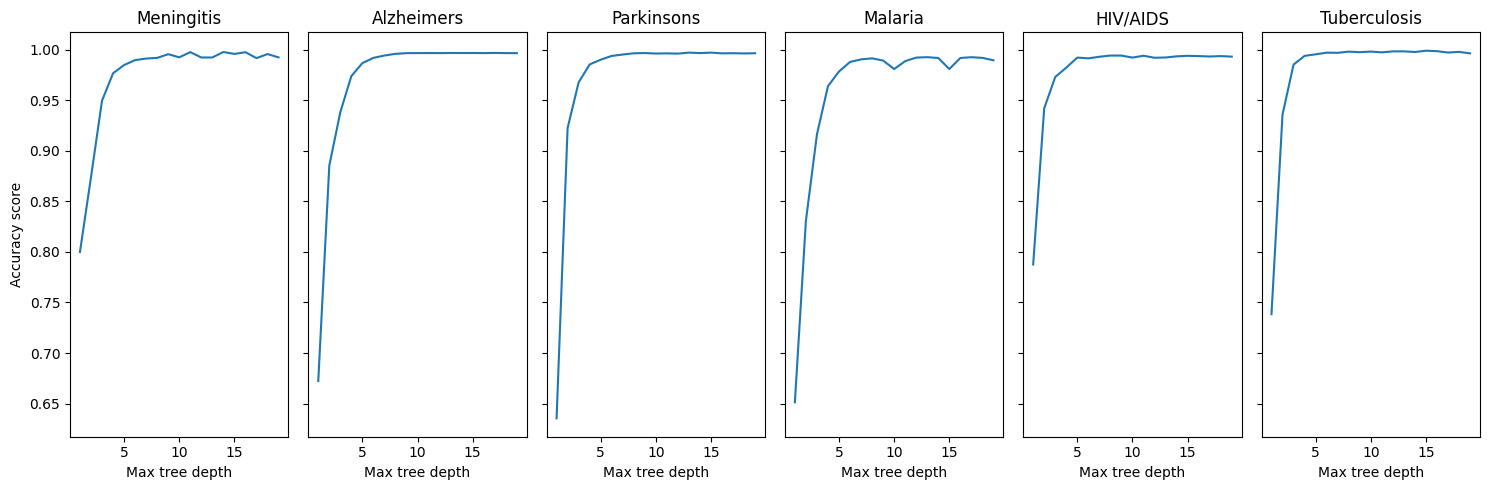

In [159]:

figure, axis = plt.subplots(1, 6, figsize=(15, 5), sharey=True)
index = 0

for i in range (31, 37):

    colname = deathsInCountries.columns[i]
    data = deathsInCountries[deathsInCountries[colname] > 0]
    
    X = data.iloc[ : , 4 : 31]
    Y = data.iloc[ : , i ]

    X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X, Y, test_size=0.3)
    X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)

    depths = range(1,20)
    accuracyScores = []
    for i in depths:
        regressor = DecisionTreeRegressor(random_state = 10,max_depth=i)
        regressor.fit(X_train, Y_train)
        score = regressor.score(X_val, Y_val)
        accuracyScores.append(score)

    axis[index].plot(depths,accuracyScores)
    axis[index].set_title(colname)
    index = index + 1
    
    predictionMetrics(colname, X_train, Y_train, X_test, Y_test)

plt.setp(axis[:], xlabel='Max tree depth')
plt.setp(axis[0], ylabel='Accuracy score')

figure.tight_layout()

From the results we can see that the model performance almost stops changing when it reaches max depth of 7. Malaria was predicted with the biggest error. Other diseases performed better than expected with mean absolute error below ±6%

To conclude, we can predict different disease death rates using death rates by various risks data with quite high accuracy (usually more than 90%).

[back to the top](#main)
<a id='Q3' name='Q3'></a>
## 3. Can we predict the number of hospital patients from new cases per million and new deaths in countries where the data exist?

Let's gather relevant data.

In [160]:
df = covidData
df = df[["new_cases_per_million", "new_deaths", "hosp_patients"]]
df.dropna()

,new_cases_per_million,new_deaths,hosp_patients
11601,7.63900,1.00000,426.00000
11602,11.68900,2.00000,441.00000
11603,9.79900,4.00000,415.00000
11604,8.25600,4.00000,457.00000
11605,8.48700,2.00000,490.00000
...,...,...,...
211051,161.25300,485.00000,22650.00000
211052,211.16500,1085.00000,22452.00000
211053,140.39300,546.00000,22125.00000
211054,217.93600,383.00000,21178.00000


Data is splitted into training, validation and testing subsets. Applied normalization.

In [164]:
data = df[["new_cases_per_million", "new_deaths", "hosp_patients"]]
data = data.dropna(subset=["new_cases_per_million", "new_deaths", "hosp_patients"])
print(data.corr())

X = data[["new_cases_per_million", "new_deaths"]]
Y = data[["hosp_patients"]]

scaler = MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(X)
Y = scaler.fit_transform(Y)

X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X, Y, test_size=0.3)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)

print(X_train.shape,Y_train.shape, X_val.shape,Y_val.shape, X_test.shape,Y_test.shape)

                       new_cases_per_million  new_deaths  hosp_patients
new_cases_per_million                1.00000     0.04283        0.06042
new_deaths                           0.04283     1.00000        0.85047
hosp_patients                        0.06042     0.85047        1.00000
(21448, 2) (21448, 1) (4596, 2) (4596, 1) (4597, 2) (4597, 1)


Constructed the model using one hidden layers with relu activation function and sigmoid for the output. Used adam algrithm based optimizer and loss is calculated using man squared error metric. After several testings with batch sizes and epochs decided to go with batch_size = 100 and epochs = 20, because they provided good accuracy and learning time.

Epoch 1/20
  1/215 [..............................] - ETA: 1:14 - loss: 0.2245 - accuracy: 0.0000e+00

2022-10-17 21:34:28.630180: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


215/215 [==============================] - ETA: 0s - loss: 0.0627 - accuracy: 0.0038

2022-10-17 21:34:30.280345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


215/215 [==============================] - 2s 8ms/step - loss: 0.0627 - accuracy: 0.0038 - val_loss: 0.0058 - val_accuracy: 0.0039
Epoch 2/20
215/215 [==============================] - 1s 7ms/step - loss: 0.0029 - accuracy: 0.0038 - val_loss: 0.0027 - val_accuracy: 0.0041
Epoch 3/20
215/215 [==============================] - 1s 6ms/step - loss: 0.0018 - accuracy: 0.0038 - val_loss: 0.0025 - val_accuracy: 0.0041
Epoch 4/20
215/215 [==============================] - 1s 6ms/step - loss: 0.0017 - accuracy: 0.0038 - val_loss: 0.0023 - val_accuracy: 0.0041
Epoch 5/20
215/215 [==============================] - 1s 6ms/step - loss: 0.0016 - accuracy: 0.0038 - val_loss: 0.0022 - val_accuracy: 0.0041
Epoch 6/20
215/215 [==============================] - 1s 7ms/step - loss: 0.0015 - accuracy: 0.0038 - val_loss: 0.0021 - val_accuracy: 0.0041
Epoch 7/20
215/215 [==============================] - 1s 6ms/step - loss: 0.0014 - accuracy: 0.0038 - val_loss: 0.0020 - val_accuracy: 0.0041
Epoch 8/20
215/21

2022-10-17 21:34:57.454581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


144/144 [==============================] - 0s 2ms/step


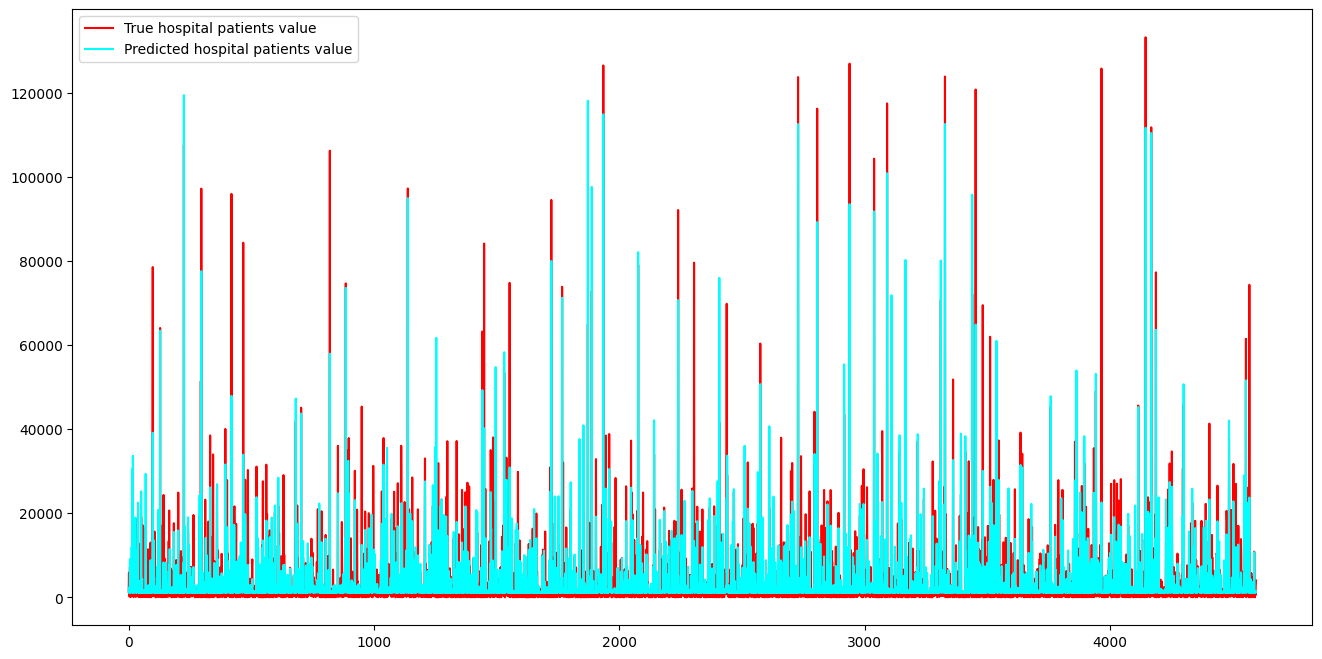

In [166]:
model = Sequential([
    Dense(32, activation='relu', input_shape=(2,)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid'),
])

model.compile(optimizer='adam',
              loss='MeanSquaredError',
              metrics=['accuracy'])

hist = model.fit(X_train, Y_train,
          batch_size=100, epochs=20,
          validation_data=(X_val, Y_val))

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

y_test_scaled = scaler.inverse_transform(Y_test.reshape(-1, 1))

fig, ax = plt.subplots(figsize=(16,8))
ax.plot(y_test_scaled, color='red', label='True hospital patients value')
plt.plot(predictions, color='cyan', label='Predicted hospital patients value')
plt.legend()


In the chart above we can see how predicted values compares with actual values. We can see that they provide quite similar charts.

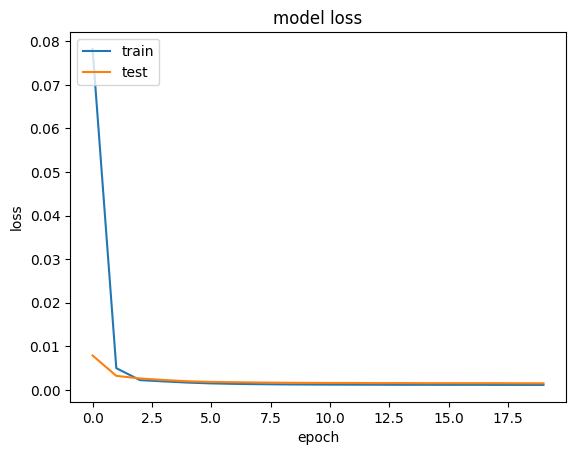

In [163]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

From the accuracy and loss we can see that model performs very effectivelly and can predict hospital patients from new cases per million and new deaths in countries with a high accuracy.